In [11]:
# import libraries
import itertools
import warnings
warnings.filterwarnings("ignore")
# 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
# 
from scipy.optimize import minimize
from scipy.stats import t
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
# globals
tickers = ['IEF', 'SHY', 'TIP', 'TLT', 'HYG', 'LQD', 'AGG', 'BND', 'EMB', 'MUB', 'PFF', '^GSPC', 'TIP', 'LQD', 'UDN', 
           'EURUSD=X', '^VIX', 'CL=F', '^IRX', '^FVX', '^TNX', '^TYX']
target = 'IEF' # iShares 7-10 Year Treasury Bond ETF
start_date = '2004-01-01'
end_date = '2024-01-01'

In [13]:
# constructs
class OptimalLinearSignal:
    def __init__(self, pivot: pd.Series, 
                 l2_reg: float = 0, l1_reg: float = 0, 
                 k_principal_components:int=0, 
                 p_value_threshold:float=0.001
                 ) -> None:
        """
        Initializes the model with specified pivot and regularization parameters 
        :param pivot: Series containing pivot data for feature transformation.
        :param l2_reg: L2 regularization parameter.
        :param l1_reg: L1 regularization parameter.
        :param k_principal_components: Number of principal components for PCA.
        :param p_value_threshold: Threshold for statistical significance in regularization.
        """
        self.pivot = pivot.copy()
        self.set_params(l2_reg, l1_reg, k_principal_components, p_value_threshold)
        self.beta_neutral = None

    ##### ##### ##### ##### ##### ##### #####
    ##### #####   PUBLIC METHODS  ##### #####
    ##### ##### ##### ##### ##### ##### #####

    def set_params(self, l2_reg: float = 0, l1_reg: float = 0, k_principal_components:int=0, p_value_threshold:float=0.001,) -> None:
        """
        Sets parameters for the model including regularization and PCA components.
        :param l2_reg: L2 regularization parameter.
        :param l1_reg: L1 regularization parameter.
        :param k_principal_components: Number of principal components for PCA.
        :param p_value_threshold: Threshold for p-value in statistical significance regularization.
        """
        self.lambda_l2 = l2_reg # L2 regularization term
        self.lambda_l1 = l1_reg # L1 regularization term
        self.pca = PCA(n_components=k_principal_components) if k_principal_components > 0 else None # Set a PCA if k_principal_components is specified
        self.p_val_threshold = p_value_threshold # Set threshold for p_value for statistic significance regularization

    def fit(self, X: pd.DataFrame) -> None:
        """
        Fit the model based on the input features X.
        :param X: DataFrame containing feature data with index aligned to pivot data.
        """
        
        self.features = list(X.columns) + ['Intercept Serie']  # Store feature names for consistency checks

        self.training_size = len(X) # Compute training size

        X_tilde = self.__transform(X) # Transform features using __transform method

        if self.pca: 
            X_tilde = self.__apply_pca(X_tilde) # Apply pca if specificied
        
        self.mu, self.sigma = np.array(X_tilde.mean()), np.array(X_tilde.cov()) # Compute mean and covariance of transformed features
        
        if self.lambda_l2: 
            self.__apply_l2_reg(self.lambda_l2) # Apply L2 regularization if specified

        if self.beta_neutral: 
            self.beta_neutral(X_tilde)
        
        self.alpha = self.__get_optimal_alpha(self.mu, self.sigma) # Get the optimal alpha values

        if self.lambda_l1: 
            self.__apply_l1_reg(self.lambda_l1) # Apply L1 regularization if specified
        
        if self.p_val_threshold: 
            self.__stat_significance_regularization(self.p_val_threshold) #Apply statistical signficance regularization if specified 

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """
        Make predictions of the Optimal Linear Signal on new data.
        :param X: DataFrame containing new feature data.
        :return: DataFrame containing the predicted signal.
        """

        if not hasattr(self, "alpha"): 
            raise ValueError("Model must be fit before prediction")
        if set(list(X.columns) + ['Intercept Serie']) != set(self.features): 
            raise ValueError("The feature names should match those that were passed during fit.")
        
        X_local = X.copy()
        X_local.loc[:, 'Intercept Serie'] = 1  # Add a constant term for the intercept

        # X_local = self.__transform(X_local) # added
        
        if self.pca: 
            X_local = self.__apply_pca(X_local) # Apply PCA that has been fitted on train data

        return X_local.dot(self.alpha) # Compute and return optimal signals
    
    def correct(self, X: pd.DataFrame) -> pd.Series:
        """
        Make predictions of the Optimal Linear PnL on new data.
        :param X: DataFrame containing new feature data.
        :return: DataFrame returns a corrective factor on the sign.
        if the uncorrected model lost money on the previous day, the signal is reversed.
        """

        if not hasattr(self, "alpha"):
            raise ValueError("Model must be fit before prediction")
        if set(list(X.columns) + ['Intercept Serie']) != set(self.features):
            raise ValueError("The feature names should match those that were passed during fit.")

        X_tilde = self.__transform(X)
    
        if self.pca:
            X_tilde = self.__apply_pca(X_tilde)

        return np.sign(X_tilde.dot(self.alpha))
    
    ##### ##### ##### ##### ##### ##### #####
    ##### #####  PRIVATE METHODS  ##### #####
    ##### ##### ##### ##### ##### ##### #####

    def __transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input features for model fitting or prediction.
        Explained in the paper: each variable is transformed to maximize PnL, linearly.
        :param X: DataFrame of input features.
        :return: Transformed DataFrame.
        """

        X_local = X.copy()
        X_local.loc[:, 'Intercept Serie'] = 1  # Add an intercept term to the features.
        X_tilde = X_local.shift(1).multiply(self.pivot.loc[X_local.index], axis=0) #X_tilde_t = X_(t-1) * (pivot_t - pivot_(t-1))
        
        return X_tilde  
    
    def __apply_pca(self, X:pd.DataFrame) -> pd.DataFrame:
        """
        Applies PCA to DataFrame 'X'. Fits PCA if not already done, then transforms 'X' using PCA components.
        Direct matrix multiplication is used instead of standard pca.transform to avoid data scaling.
        """

        if not hasattr(self.pca, "components_"):
            self.pca.fit(X.ffill().fillna(0)) # Fit the PCA if it has not been fit yet
        
        return pd.DataFrame(X.dot(self.pca.components_.T), index=X.index)
        # Instead of the standard pca.transform method, direct matrix multiplication with PCA components is used. 
        # This approach is chosen because the standard pca.transform method scales the data before projection, 
        # which is not desired in this specific context. This detail is crucial as scaling can significantly alter 
        # the data characteristics, leading to different results.

    def __apply_l2_reg(self, l2_param:float) -> None:
        """
        Applies L2 regularization to the covariance matrix.
        Parameters:
        l2_param: L2 regularization parameter.
        Modifies sigma in place to include L2 regularization effect.
        """
        self.sigma += l2_param * (np.linalg.norm(self.sigma, ord='fro') + 1e-8) / len(self.sigma) * np.eye(len(self.sigma))
        self.sigma /= (1 + l2_param)

    def __get_optimal_alpha(self, mu: np.array, sigma: np.array) -> np.array:
        """
        Conducts optimization to determine the optimal alpha coefficients.
        Parameters:
        mu (np.array): The mean vector of the transformed features.
        sigma (np.array): The covariance matrix of the transformed features.
        Returns:
        np.array: Optimal alpha coefficients.
        """

        # Verify if Sigma matrix is invertible
        if np.linalg.det(sigma) == 0: 
            raise ValueError("Cov matrix must be invertible, try increasing lambda_reg.")

        # Compute optimal alpha 
        sigma_inv = np.linalg.inv(sigma)
        alpha_hat = sigma_inv.dot(mu) / np.sqrt(mu.dot(sigma_inv.dot(mu)))

        return alpha_hat  
    
    def __apply_l1_reg(self, l1_param:float) -> None:
        """
        Applies L1 regularization to the alpha coefficients using an optimization approach.
        Parameters:
        l1_param: L1 regularization parameter.
        Updates alpha using L1 loss minimization.
        """

        alpha = self.alpha
        mu = self.mu
        sigma = self.sigma
        lambda_l1_true = l1_param * alpha.dot(mu)

        loss = lambda alpha: - alpha.dot(mu) + lambda_l1_true * np.abs(alpha).sum()
        grad_loss = lambda alpha: (sigma.dot(alpha) - mu) + lambda_l1_true * np.sign(alpha).sum()
        constraint = {'type': 'eq', 'fun': lambda alpha: alpha.dot(sigma.dot(alpha)) - 1}

        self.alpha = minimize(fun=loss, jac=grad_loss, constraints=constraint, x0=alpha, method='SLSQP').x
    
    def __stat_significance_regularization(self, p_value_threshold:float):
        """
        Applies t-test regularization to adjust the insignificant alpha coefficients to 0.

        Note: 
        - The method mutates 'self.alpha' directly.
        """

        #A lambda function 'p_val' is defined to calculate the two-tailed p-value for a t-distribution. 
        #It uses the cumulative distribution function (CDF) of the t-distribution.
        p_val = lambda val, k: 2 * min(t.cdf(val, k), 1 - t.cdf(val, k))

        #The 'alpha_test' variable is calculated by normalizing the alpha coefficients      
        alpha_test =  self.alpha * self.alpha.dot(self.mu) * np.sqrt(self.training_size)

        # The alpha coefficients are then iteratively checked against the p-value threshold. 
        # If the p-value for a coefficient (calculated using 'alpha_test') is greater than the threshold, 
        # that coefficient is set to zero, indicating it is statistically insignificant
        for i, alpha_test_i in enumerate(alpha_test): 
            if p_val(alpha_test_i, self.training_size - 1) <= p_value_threshold: self.alpha[i]=0

def moving_Zscore(df: pd.DataFrame, window_size_zs: int = 30) -> pd.DataFrame:
    """
    Calculate the Z-Score for each column in a DataFrame over a rolling window.
    
    Parameters:
    - df (pd.DataFrame): DataFrame to calculate Z-Scores for.
    - window_size_zs (int): Size of the rolling window for Z-Score calculation.

    Returns:
    - pd.DataFrame: DataFrame of Z-Scores.
    """
    # Return original DataFrame or DataFrame of 1s based on the window size
    if window_size_zs == 0: 
        return df
    else :
        # Calculate Z-Score using rolling mean and standard deviation
        m_zscore = (df - df.rolling(window=window_size_zs).mean()) / (df.rolling(window=window_size_zs).std() + 1e-8)

        return m_zscore
    
def compute_position(signals_df: pd.DataFrame, prices_df: pd.DataFrame, window_size: int = 100, threshold: int = 0) -> pd.DataFrame:
    """
    Compute trading positions based on signals and stock prices.

    Parameters:
    - signals (pd.DataFrame): DataFrame containing trading signals.
    - prices (pd.DataFrame): DataFrame containing stock prices.
    - window_size (int): Size of the rolling window for signal processing.
    - threshold (int): Threshold for signal strength to take a position.

    Returns:
    - pd.DataFrame: DataFrame containing trading positions.
    """
    # Initialize a DataFrame to store positions
    positions_df = pd.DataFrame(index=signals_df.index)
    
    if threshold>0: # Compute Z-scores for signals and set positions where signals exceed the threshold
        zscore_signal = moving_Zscore(signals_df, window_size_zs=window_size).ffill().fillna(0)
        signals_df = signals_df.where(zscore_signal.abs() > threshold, 0)

    positions_df = signals_df.multiply(prices_df, axis=0)

    return positions_df

def compute_PNL(positions_df: pd.DataFrame, prices_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute Profit and Loss (PNL) from trading positions and price changes.

    Parameters:
    - positions (pd.DataFrame): DataFrame containing trading positions.
    - prices (pd.DataFrame): DataFrame containing stock prices.

    Returns:
    - pd.DataFrame: DataFrame containing daily and cumulative PNL.
    """

    # Initialize a DataFrame for PNL
    pnl_df = pd.DataFrame(index=prices_df.index)
    

    # Calculate daily PNL based on position changes and price movements
    pnl_per_asset_df = positions_df.shift(1).multiply(prices_df.pct_change(), axis=0)
    pnl_df["DAILY"] = pnl_per_asset_df.sum(axis=1) 
    pnl_df["CUMULATIVE"] = pnl_df["DAILY"].cumsum()

    return pnl_df

def compute_metrics(pnl_df: pd.DataFrame, positions_df: pd.DataFrame) -> dict[str, float]:
    """
    Compute various performance metrics for the trading strategy.

    Parameters:
    - pnl (pd.DataFrame): DataFrame containing daily PNL data.
    - positions (pd.DataFrame): DataFrame containing trading positions.

    Returns:
    - dict[str, float]: Dictionary containing key performance metrics.
    """
    # Calculate daily pnl and absolute positions
    pnl_daily = pnl_df['DAILY']
    positions_abs_sum = positions_df.abs().sum(axis=1)

    # Compute Sharpe Ratio and other metrics
    sharpe_ratio = np.sqrt(252) * pnl_daily.mean() / pnl_daily.std()
    turnover = 100 * positions_abs_sum.diff().abs().mean() / positions_abs_sum.abs().mean()
    bips = 100 * 100 * pnl_daily.mean() / positions_abs_sum.diff().abs().mean()

    # Compute effective metrics considering only non-zero positions
    freq_trading = (positions_df.abs().sum(axis=1) != 0).sum() / len(positions_df)

    # Return metrics as a dictionary
    return {
        'sharpe_ratio': round(sharpe_ratio, 2), 
        'turnover': round(turnover, 1), 
        'bips': round(bips, 1), 
        'effective_sharpe_ratio': round(sharpe_ratio / np.sqrt(freq_trading), 2), 
        'eff_turnover': round(turnover/freq_trading, 2)
    }

def plot_ds_hue(ds: pd.Series, ds_hue: pd.Series, title: str = ''):
    """
    Plot a Series with points colored based on another Series.
    
    Parameters:
    - ds (pd.Series): Series to plot.
    - ds_hue (pd.Series): Series used to color the points.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('USD (scaled on: 25kUSD / std risk)')

    # Warn if the Series is constant
    if ds.std() == 0: 
        print(f'Warning: ds is constant.')
        return
    elif ds_hue.std() == 0: 
        print(f'Warning: ds_hue is constant.')
        return
    
    # Scale the Series
    ds_scaled = 25 * 1000 * ds / ds.std()

    # Plot daily and cumulative lines
    sns.lineplot(x=ds_scaled.index, y=ds_scaled, color="lightblue", linewidth=0.7, label='Daily')
    sns.lineplot(x=ds_scaled.index, y=ds_scaled.cumsum(), color="grey", linewidth=0.7, label='Cumulative')

    # Scale the hue data
    window_size = 100 
    ds_hue_scaled = (ds_hue - ds_hue.rolling(window=window_size).mean()) / (ds_hue.rolling(window=window_size).std() + 1e-8)
    ds_hue_scaled = ds_hue_scaled.abs()
    ds_hue_scaled.fillna(0, inplace=True)

    # Cap extreme values and plot as scatter
    ds_hue_filtered = np.where(ds_hue_scaled.abs() > 2, np.sign(ds_hue_scaled) * 2, ds_hue_scaled)
    sns.scatterplot(x=ds_scaled.index, y=ds_scaled.cumsum(), 
                    hue=ds_hue_filtered, size=np.abs(ds_hue_filtered), 
                    palette="coolwarm", hue_order=[0, 1, 2])#, label='Signal'
    plt.legend()
    plt.show()

def compute_signal_OLS(pivot: pd.DataFrame, X: pd.DataFrame, 
                           training_size: int = 10, k_components:int=0, 
                           l2_reg:float=1, l1_reg:float=0, p_val:float=0.001,)->pd.DataFrame:
    
    signal = pd.DataFrame(index=pivot.index, columns=pivot.columns)
    
    for index_ticker, ticker in enumerate(pivot.columns):
        model = OptimalLinearSignal(pivot[ticker].diff(), l2_reg, l1_reg, k_principal_components=k_components, p_value_threshold=p_val)
        scaler = StandardScaler()
        #model.make_beta_neutral(pivot[ticker])
        
        # Initialize DataFrame for predicted prices
        signal.iloc[:training_size, index_ticker] = np.nan  # Filling with NaN
        
        # Perform online training and prediction, using training sizes for batches
        for p in range(1, len(pivot) // training_size):
            index_day = p * training_size
            X_train = X.iloc[index_day - training_size: index_day-1, :].replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
            model.fit(X_train_scaled)
            
            X_day = X.iloc[index_day : index_day + training_size, :].replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
            X_scaled = pd.DataFrame(scaler.transform(X_day), columns=X_day.columns, index=X_day.index)

            predicted_signal = model.predict(X_scaled).values
            corrective_term = model.correct(X_scaled).values
            signal.iloc[index_day : index_day + training_size, index_ticker] = predicted_signal * corrective_term

    return signal.ffill()

def evaluate_OLS_strat(ts: int, k:int = 1, l2:float=1, l1:float=0, pvt:float=0.001, metric:str='sharpe_ratio') -> float:

    global prices_df, X
    
    pivot = prices_df[[target]]
    try: 
        signal = compute_signal_OLS(pivot, X, training_size=ts, k_components=k, l2_reg=l2, l1_reg=l1, p_val=pvt)
    except ValueError: 
        return 0 
    positions = compute_position(signal, prices_df, threshold=1.5)
    pnl = compute_PNL(positions, prices_df)
    return compute_metrics(pnl, positions)[metric]

def show_strat_OLS(prices: pd.DataFrame, X: pd.DataFrame, ts: int, k:int, l2:float, l1:float=0, pvt:float=0.001):
    """
    Demonstrates a trading strategy based on OLS and visualizes the results.
    """

    print({'ts':ts, 'k':k, 'l2':l2, 'l1':l1, 'pvt':pvt})

    pivot = prices[[target]]
    try: 
        signal = compute_signal_OLS(pivot, X, training_size=ts, k_components=k, l2_reg=l2, l1_reg=l1, p_val=pvt)
    except ValueError as e: 
        return print('No signal, ValueError:', e)
         
    positions = compute_position(signal, prices, threshold=1.5)
    pnl = compute_PNL(positions, prices)
    print(compute_metrics(pnl, positions))
    plot_ds_hue(pnl['DAILY'], pd.Series(signal.abs().mean(axis=1), index=signal.index), 
                title=f"PnL {target}", #period=['2019-06-01', '2022-06-01']
                )
    
def grid_search(f: callable, param_dict: dict):
    """
    Perform grid search for optimal parameters of a function.
    """
    # Generate all parameter combinations
    keys, values = zip(*param_dict.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # Initialize best parameters and result
    best_params = {}
    best_result = 0

    # Evaluate function for each parameter combination
    for params in param_combinations:
        try: result = f(**params)
        except ValueError: result = 0 

        # Update best result and parameters
        if result > best_result:
            best_params = params
            best_result = result

    return best_params, best_result
    
def axial_grid_search(f:callable, param_dict:dict, param_selected:str):
    """
    Visualizes the impact of varying a selected parameter on the performance metric.

    :param param_dict: Dictionary of parameter grids.
    :param param_selected_valected: The parameter to vary.
    :param f: Callable function for evaluation (e.g., evaluate_OLS_strat).
    """
    param_selected_values = param_dict[param_selected]
    param_dict_cut = {key: val for key, val in param_dict.items() if key != param_selected}

    best_params_values = []
    best_result_values = []
    eff_result_values = []
    for i, param_selected_val in enumerate(param_selected_values):
        best_params, best_result = grid_search(f, {**{param_selected: [param_selected_val]}, **param_dict_cut})
        best_params_values.append(best_params)
        best_result_values.append(best_result)
        try: eff_result_values.append(f(**{**best_params, **{'metric': 'effective_sharpe_ratio'}}))
        except TypeError: eff_result_values.append(0)
        print(i+1,'/',len(param_selected_values), end=', \n')

    df = pd.DataFrame({
        param_selected: param_selected_values,
        'sharpe': best_result_values,
        'eff_sharpe': eff_result_values
    })

    plt.figure(figsize=(10, 5))
    plt.title(f'{param_selected} -> max(sharpe({param_selected}, param_2, ..., param_n) for param_2, ..., param_n in grid)')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.lineplot(data=df, x=param_selected, y='sharpe', label='Sharpe Ratio')
    sns.lineplot(data=df, x=param_selected, y='eff_sharpe', label='Effective Sharpe Ratio')
    plt.legend()
    plt.show()

    return best_params_values, best_result_values

In [14]:
# Download data
data = {ticker: yf.download(ticker, start=start_date, end=end_date) for ticker in tickers}
# Initialize a DataFrame to store price data
prices_df = pd.DataFrame()
# Populate the DataFrame with selected price types for each ticker
for ticker in tickers:
    prices_df[f'{ticker}'] = data[ticker]['Open']
# Fill missing values with the last available value
prices_df = prices_df.resample('1B').ffill()

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

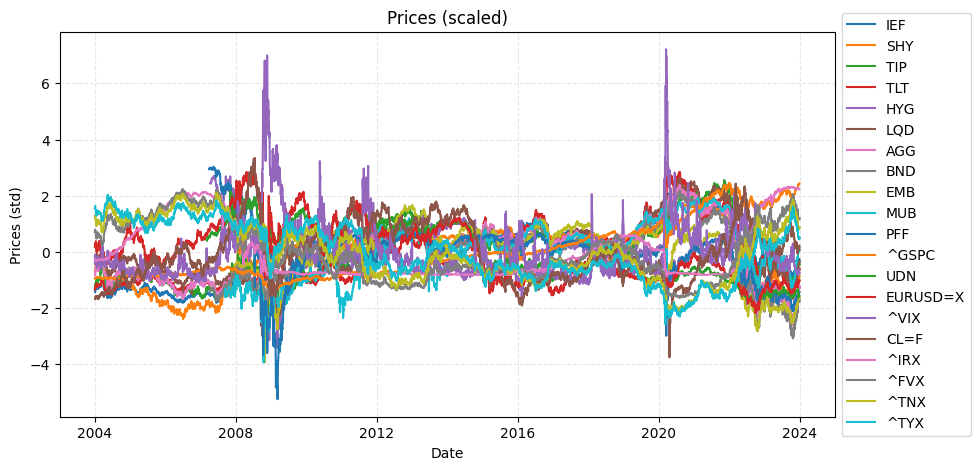

In [15]:
# plot data
local_df = prices_df.copy()
plt.figure(figsize=(10, 5))
# Scale data if required
local_df = (local_df - local_df.mean()) / local_df.std() 
plt.title('Prices (scaled)')
plt.xlabel('Date')
plt.ylabel(f'Prices (std)')
# Plot each column in the DataFrame
for col in local_df.columns: 
    sns.lineplot(x=local_df.index, y=local_df[col], label=col)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [16]:
# get features
X = pd.concat([prices_df.copy(),
               pd.DataFrame(prices_df.diff(), index=prices_df.index, columns=[str(col)+'.diff' for col in prices_df.columns]),
               pd.DataFrame(prices_df.pct_change(), index=prices_df.index, columns=[str(col)+'.pct_change' for col in prices_df.columns]),
    ], axis=1)

{'ts': 60, 'k': 35, 'l2': 10, 'l1': 0.1, 'pvt': 0.001}
{'sharpe_ratio': -0.06, 'turnover': 35.9, 'bips': -3.3, 'effective_sharpe_ratio': -0.13, 'eff_turnover': 157.89}


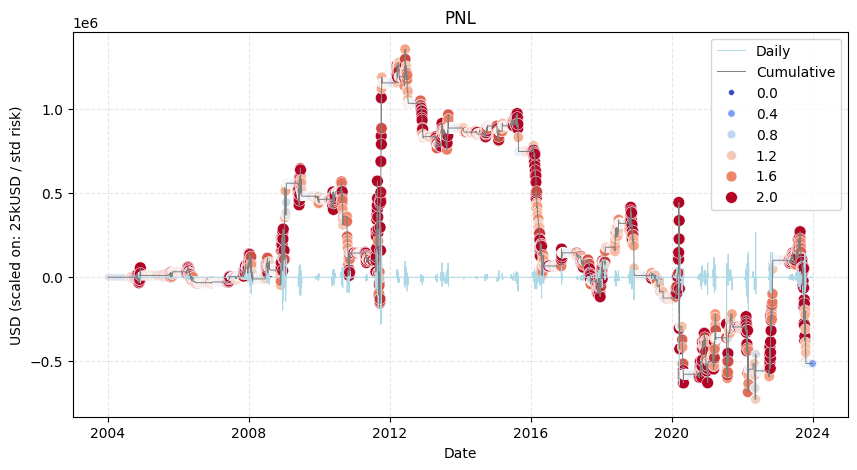

{'ts': 75, 'k': 6, 'l2': 1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.14, 'turnover': 34.1, 'bips': 15.4, 'effective_sharpe_ratio': 0.31, 'eff_turnover': 159.95}


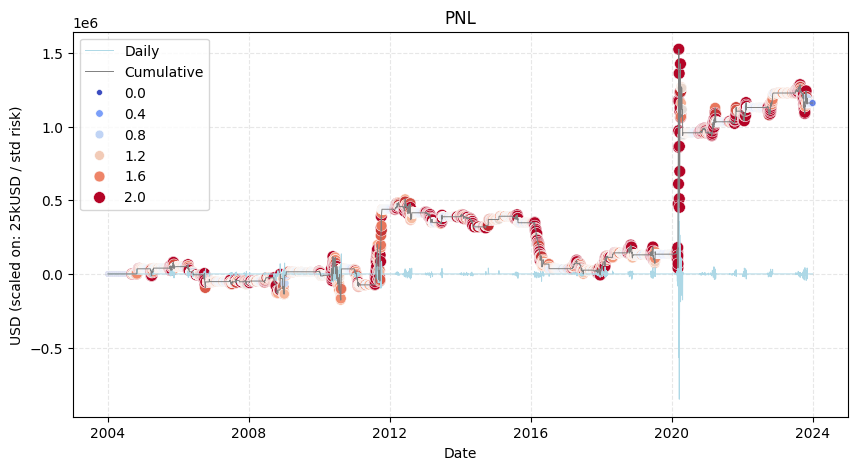

In [17]:
# show two different trajectory of the PnL using 2 different parameters set
show_strat_OLS(prices_df, X, ts=60, k=35, l2 = 10, l1=0.1,)
show_strat_OLS(prices_df, X, ts=75, k=6, l2=1,)

1 / 15, 
2 / 15, 
3 / 15, 
4 / 15, 
5 / 15, 
6 / 15, 
7 / 15, 
8 / 15, 
9 / 15, 
10 / 15, 
11 / 15, 
12 / 15, 
13 / 15, 
14 / 15, 
15 / 15, 


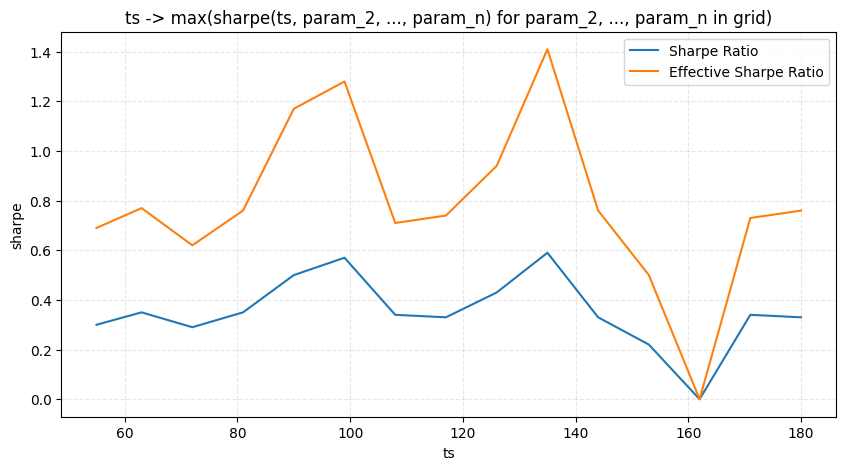

In [18]:
# perform grid search optimization for wz1, wz2, wvt parameters for zscore strat
param_grid = {
    # training size
    'ts': np.linspace(55, 180, 15, dtype=int).tolist(),
    # PCA components
    'k': [0, 1, 3, 5,] + np.linspace(6, len(X.columns)-1, 6, dtype=int).tolist(),
    # l2 regularization
    'l2': [0.1],# 10, 0, 0.1, 0.5, 1, ],
    # l1 regularization
    'l1': [0],
    # t-test (p-value) regularization to adjust the insignificant alpha coefficients to 0. 
    'pvt': [0.001]#, 0.01, 0.1, 0.4, 0.9]

} # Note that there is just a few params for each 'ts'

best_param_values, _ = axial_grid_search(evaluate_OLS_strat, param_dict=param_grid, param_selected='ts')

{'ts': 55, 'k': 27, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.3, 'turnover': 36.3, 'bips': 34.8, 'effective_sharpe_ratio': 0.69, 'eff_turnover': 188.24}


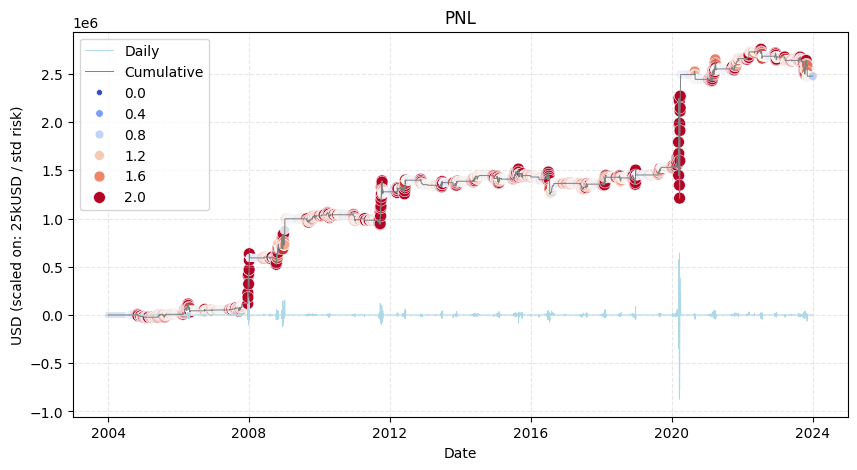

{'ts': 63, 'k': 59, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.35, 'turnover': 36.6, 'bips': 18.4, 'effective_sharpe_ratio': 0.77, 'eff_turnover': 180.63}


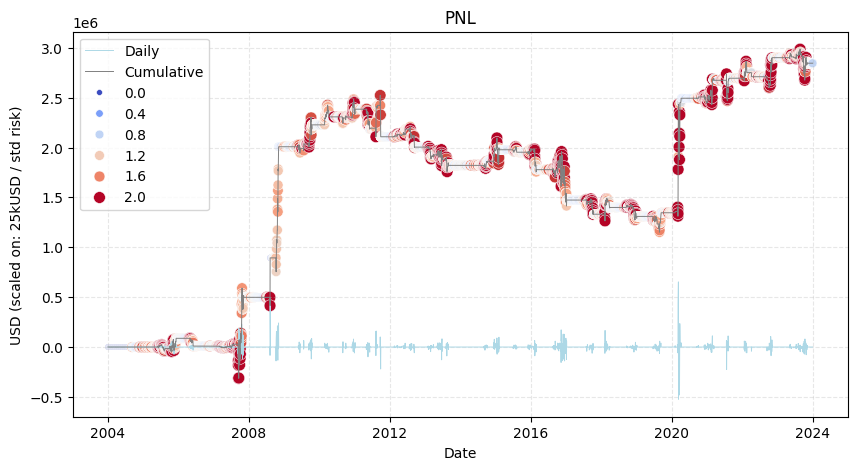

{'ts': 72, 'k': 48, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.29, 'turnover': 36.6, 'bips': 26.4, 'effective_sharpe_ratio': 0.62, 'eff_turnover': 168.77}


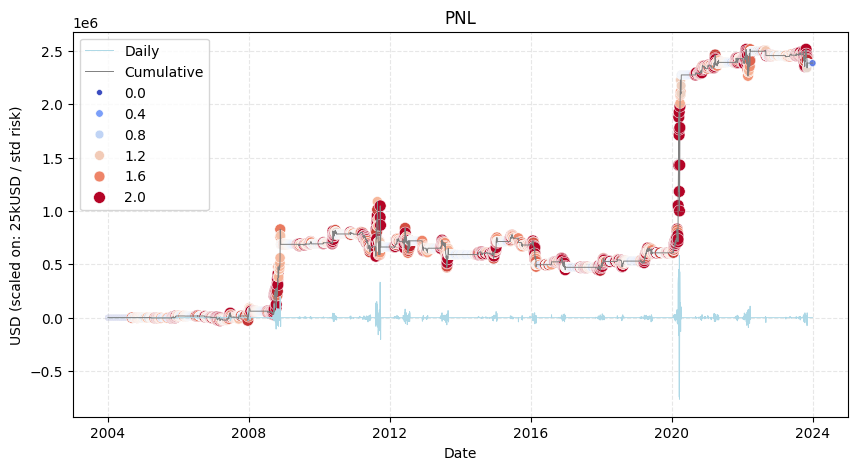

{'ts': 81, 'k': 16, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.35, 'turnover': 31.9, 'bips': 24.5, 'effective_sharpe_ratio': 0.76, 'eff_turnover': 150.0}


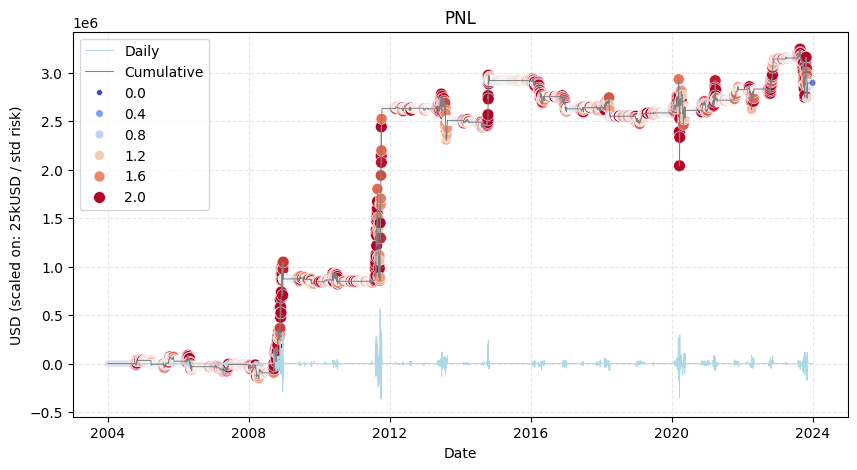

{'ts': 90, 'k': 0, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.5, 'turnover': 36.4, 'bips': 29.6, 'effective_sharpe_ratio': 1.17, 'eff_turnover': 201.56}


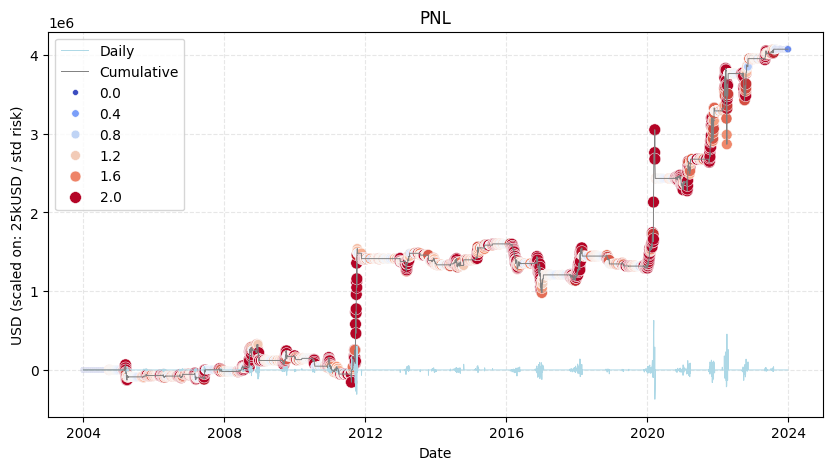

{'ts': 99, 'k': 48, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.57, 'turnover': 38.6, 'bips': 38.7, 'effective_sharpe_ratio': 1.28, 'eff_turnover': 198.05}


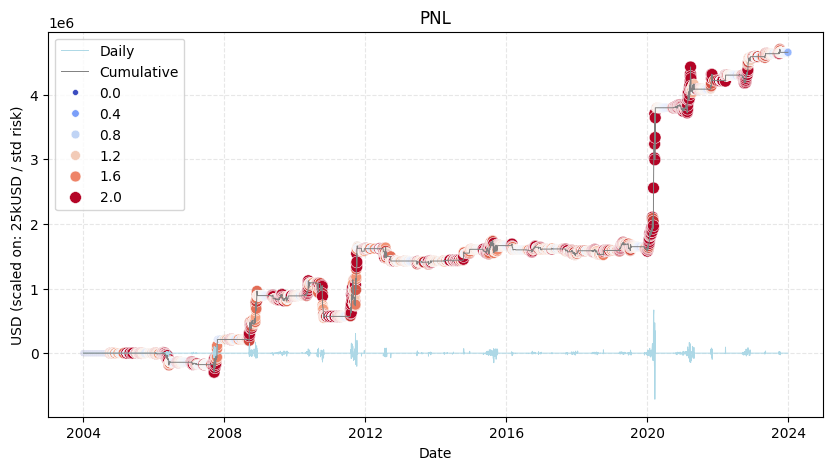

{'ts': 108, 'k': 6, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.34, 'turnover': 31.5, 'bips': 33.1, 'effective_sharpe_ratio': 0.71, 'eff_turnover': 136.04}


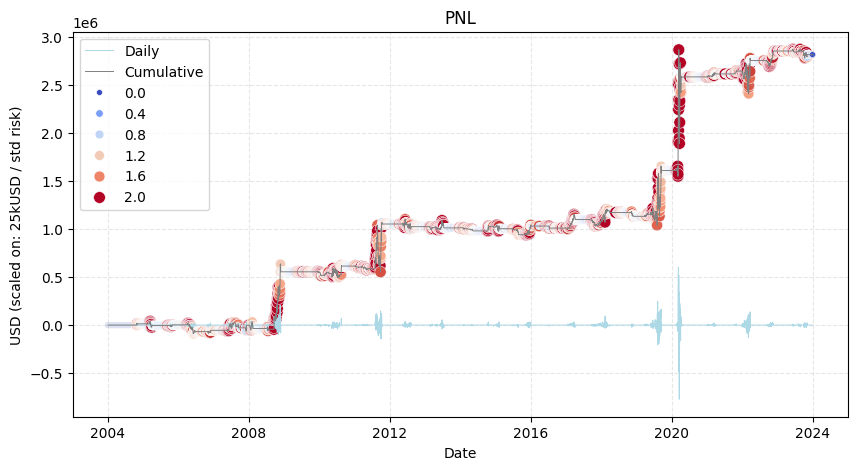

{'ts': 117, 'k': 59, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.33, 'turnover': 37.6, 'bips': 19.3, 'effective_sharpe_ratio': 0.74, 'eff_turnover': 187.55}


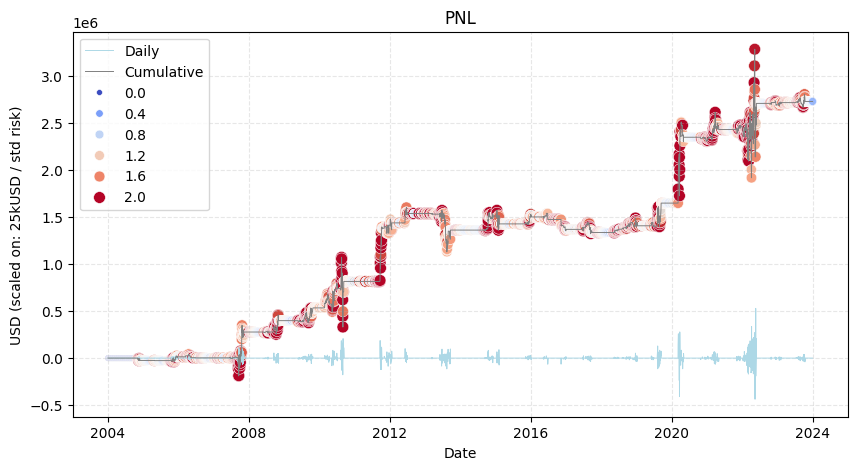

{'ts': 126, 'k': 37, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.43, 'turnover': 27.0, 'bips': 36.1, 'effective_sharpe_ratio': 0.94, 'eff_turnover': 131.68}


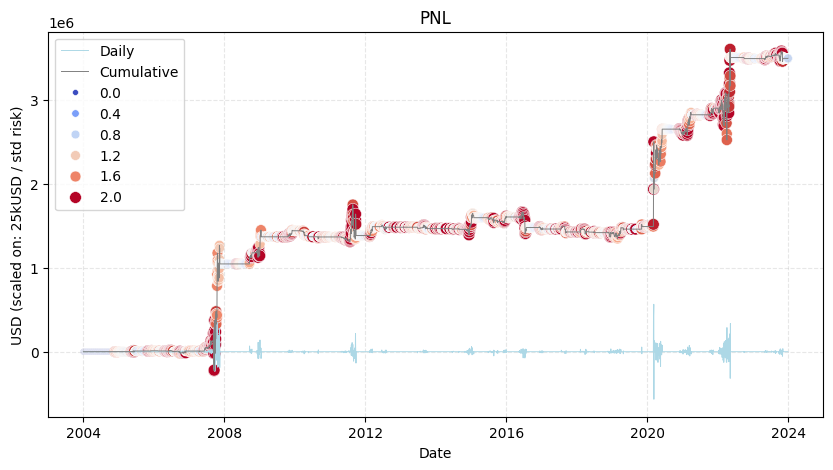

{'ts': 135, 'k': 48, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.59, 'turnover': 39.9, 'bips': 26.7, 'effective_sharpe_ratio': 1.41, 'eff_turnover': 228.67}


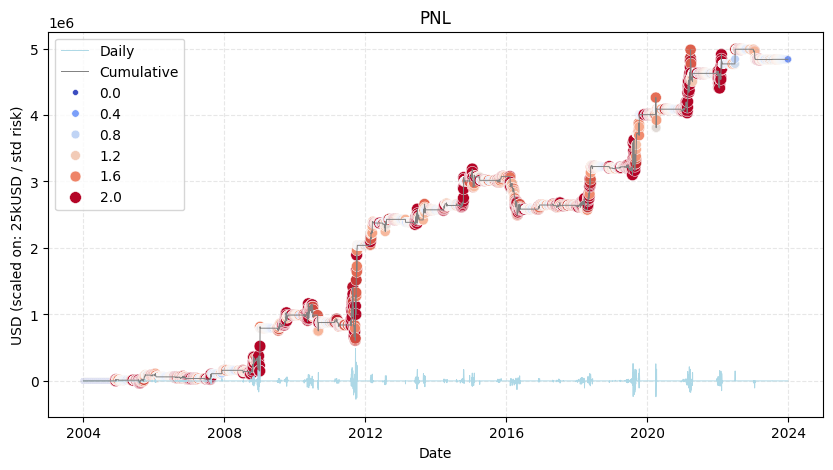

{'ts': 144, 'k': 6, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.33, 'turnover': 40.5, 'bips': 16.7, 'effective_sharpe_ratio': 0.76, 'eff_turnover': 217.77}


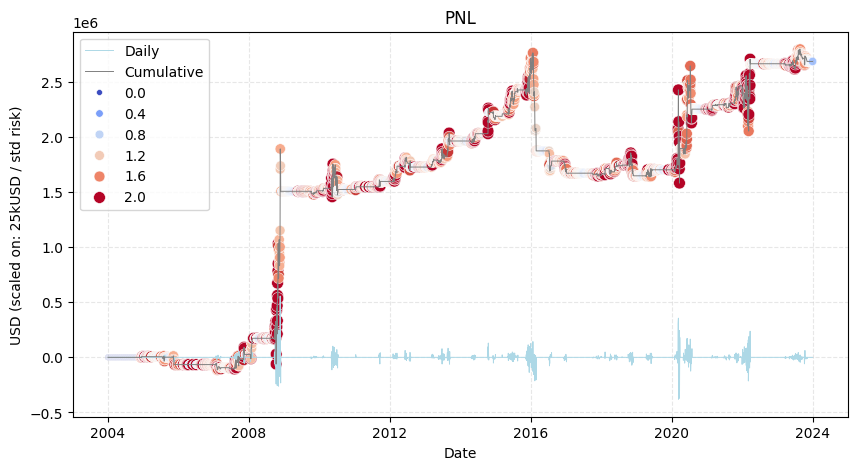

{'ts': 153, 'k': 27, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.22, 'turnover': 40.6, 'bips': 11.1, 'effective_sharpe_ratio': 0.5, 'eff_turnover': 215.48}


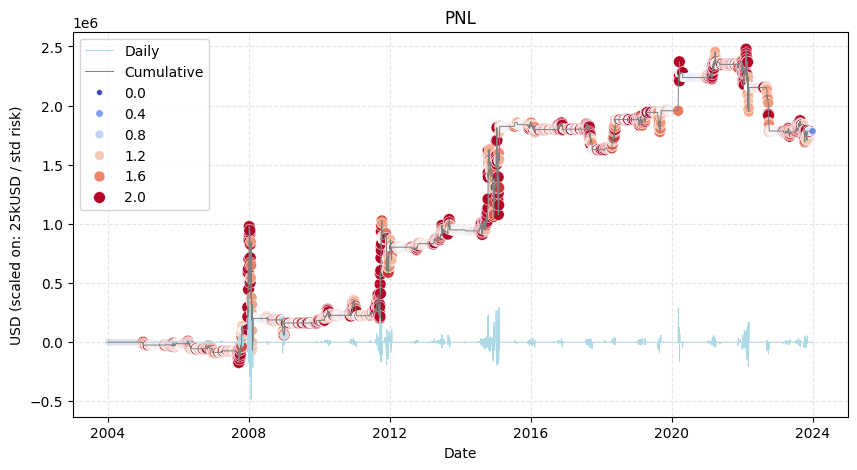

TypeError: show_strat_OLS() missing 3 required positional arguments: 'ts', 'k', and 'l2'

In [19]:
for params in best_param_values:
    show_strat_OLS(prices_df, X, **params)